# Analysis of restaurant reviews

In this notebook we analyze the Iens restaurant reviews for a city and a specific date.

In case gbq is not working you might need to update the python api client library:

```bash
sudo pip install --upgrade google-api-python-client
```

In [108]:
import pandas as pd
import numpy as np
import pandas_gbq as gbq 
import json
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# hide warnings. `gbq.read_gbq()` gives some
import warnings
warnings.filterwarnings('ignore')

In [2]:
# project specifics
PRIVATE_KEY = '../google-credentials/gsdk-credentials.json'
PROJECT_ID = json.load(open(PRIVATE_KEY))['project_id']

In [3]:
# dataset specifics
city = 'amsterdam'
date = '20171228'
bq_table = '_'.join(['iens.iens_comments', city, date])

In [4]:
# dataset specifics (restaurants info)
bq_table_restaurants = '_'.join(['iens.iens', city, date])

## Reading from BigQuery

To load a BigQuery table into a Pandas dataframe, all you need is a query, the project_id, and a way to authenticate.

In [5]:
query = "SELECT * FROM {}".format(bq_table)

df = gbq.read_gbq(query, project_id=PROJECT_ID, private_key=PRIVATE_KEY)

Requesting query... ok.
Job ID: job_W3d1rVPW7bjWwYPKlldF7ZcK3XKG
Query running...
Query done.
Processed: 46.1 MB
Standard price: $0.00 USD

Retrieving results...
  Got page: 1; 18% done. Elapsed 10.08 s.
  Got page: 2; 42% done. Elapsed 16.2 s.
  Got page: 3; 68% done. Elapsed 21.72 s.
  Got page: 4; 86% done. Elapsed 27.38 s.
  Got page: 5; 100% done. Elapsed 31.58 s.
Got 93541 rows.

Total time taken 33.1 s.
Finished at 2017-12-31 12:04:49.


In [6]:
df.shape

(93541, 10)

In [7]:
query_restaurants = "SELECT * FROM {}".format(bq_table_restaurants)

df_restaurants = gbq.read_gbq(query_restaurants, project_id=PROJECT_ID, private_key=PRIVATE_KEY)

Requesting query... ok.
Job ID: job_qdumXe7jUkPo601PwcgdL8VezHGz
Query running...
Query done.
Processed: 895.2 KB
Standard price: $0.00 USD

Retrieving results...
  Got page: 2; 100% done. Elapsed 7.7 s.
Got 20939 rows.

Total time taken 8.47 s.
Finished at 2017-12-31 12:04:58.


In [8]:
df_restaurants.shape

(20939, 25)

In [9]:
df_res = df_restaurants.drop('tags', axis=1).drop_duplicates()
df_res.shape

(2827, 24)

# Analysis

## Working title: Niet omdat het moet, maar omdat het kan
## Working title: Data-driven lunching


## Wishlist
* normalize reviews based on overall distribution -> same restaurant still the best?
    * only few percent of reviewers has more than 10 reviews


In [10]:
df['date'] = pd.to_datetime(df['date'])
df['yearmonth'] = df['date'].dt.strftime('%Y-%m')
df['year'] = df['date'].dt.strftime('%y')
df['month'] = df['date'].dt.strftime('%m')

In [11]:
df.head().T

,0,1,2,3,4
name,Dynasty,Dynasty,Levant,Levant,Levant
reserved_online,False,False,True,False,True
id,219781,219781,220293,220293,220293
rating_service,7,7,9,9,9
date,2012-09-12 00:00:00,2013-04-12 00:00:00,2016-02-05 00:00:00,2014-02-01 00:00:00,2016-02-13 00:00:00
rating_food,9,9,8,8,8
rating_decor,8,8,8,8,8
reviewer,Diede van O.,Cecilia V.,Kirsten D.,Peter T.,Daphne D.
rating,8.3,8.3,8.3,8.3,8.3
comment,Heerlijke aziatische gerechten. Vooral de 'Sec...,Echt een restaurant om lekker een avondje lang...,Het restaurant oogt erg chique. Personeel is e...,Zaterdagavond hier gegeten. De ontvangst was h...,"Relaxte sfeer, heerlijk en smaakvol eten! Fijn..."


In [102]:
df.groupby('reviewer').count().name.value_counts().to_frame().sort_index()[10:].sum()

name    1295
dtype: int64

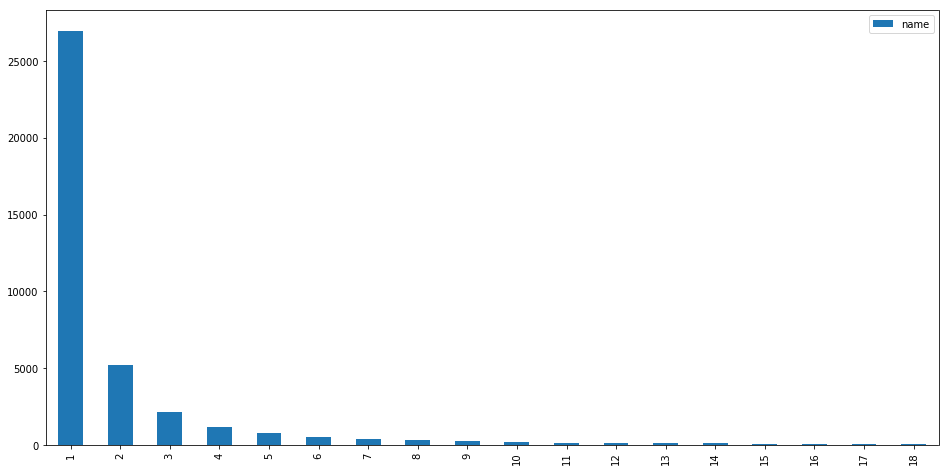

In [98]:
df.groupby('reviewer').count().name.value_counts().to_frame().query('name>50').sort_index().plot.bar(figsize=(16,8))

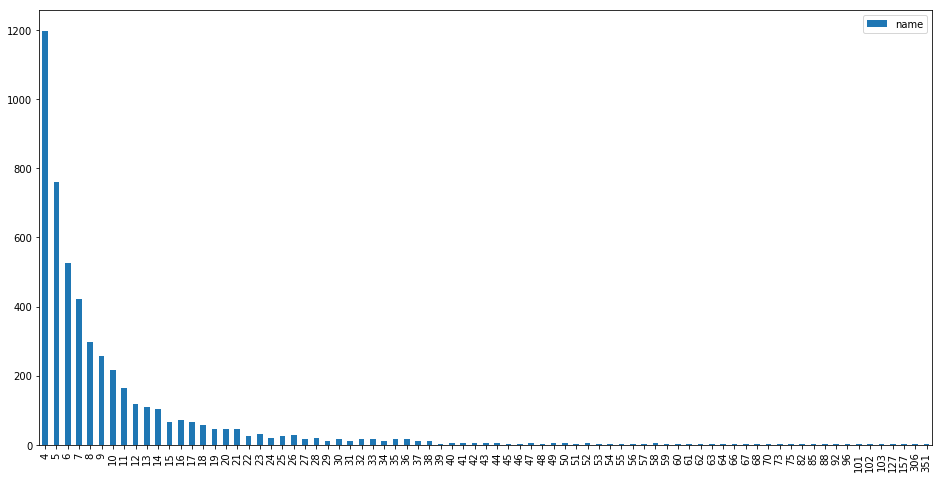

In [99]:
df.groupby('reviewer').count().name.value_counts().to_frame().sort_index()[3:].plot.bar(figsize=(16,8))

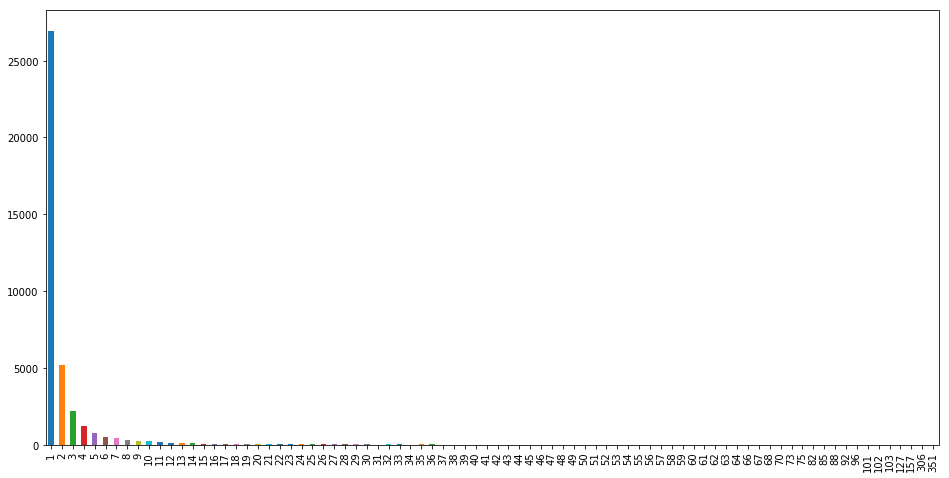

In [80]:
# number of reviews per reviewer
df.groupby('reviewer').count().name.value_counts().sort_index().plot.bar(figsize=(16,8))

## Overall review scores

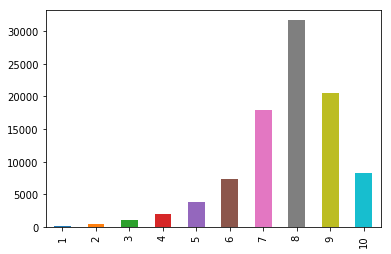

In [12]:
# Cijfer distributie
df.rating.astype(int).value_counts().sort_index().plot.bar()

## Reviewer that use specific word

In [13]:
import re

In [14]:
def search_for_word(word, df, minimum_number_of_occurences=1):
    df = df.copy()
    df[word] = df.apply(lambda x: sum(1 for match in re.finditer(r"\b"+re.escape(word)+r"\b" , x.comment)), axis='columns')
    df_word = df[df[word] >= minimum_number_of_occurences]
    print(f'Total reviews with {minimum_number_of_occurences} times the word {word}:', len(df_word), f'\nTotal review overall: {len(df)}')
    df_word.rating.astype(int).value_counts().sort_index().plot.bar()

Total reviews with 1 times the word slecht: 2585 
Total review overall: 93541


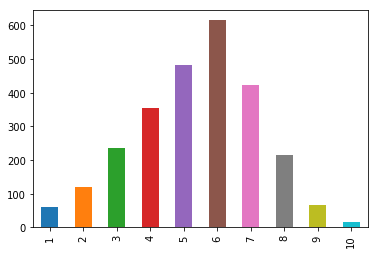

In [15]:
search_for_word('slecht', df, minimum_number_of_occurences=1)

Total reviews with 2 times the word slecht: 226 
Total review overall: 93541


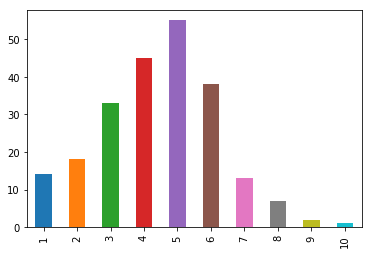

In [16]:
search_for_word('slecht', df, minimum_number_of_occurences=2)

Total reviews with 3 times the word slecht: 30 
Total review overall: 93541


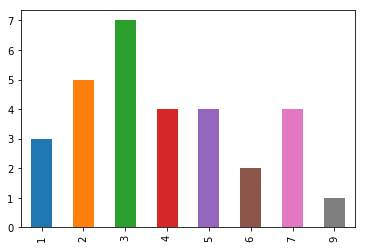

In [17]:
search_for_word('slecht', df, minimum_number_of_occurences=3)

Total reviews with 1 times the word top: 6495 
Total review overall: 93541


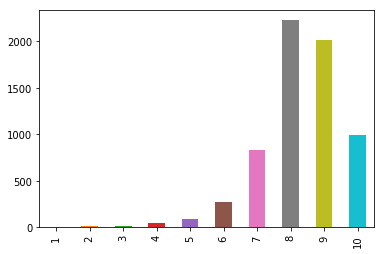

In [18]:
search_for_word('top', df)

## More use of the word 'lekker' does not increase score

Total reviews with 1 times the word lekker: 27838 
Total review overall: 93541


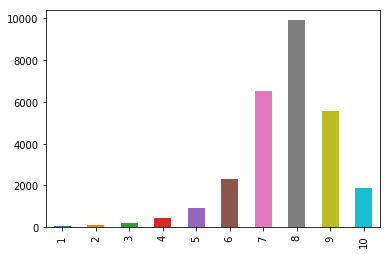

In [26]:
search_for_word('lekker', df)

Total reviews with 2 times the word lekker: 5729 
Total review overall: 93541


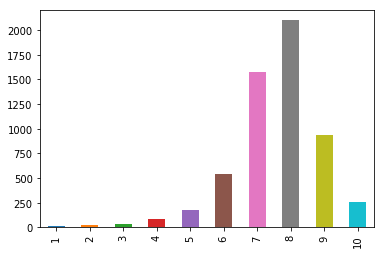

In [27]:
search_for_word('lekker', df, minimum_number_of_occurences=2)

Total reviews with 3 times the word lekker: 1269 
Total review overall: 93541


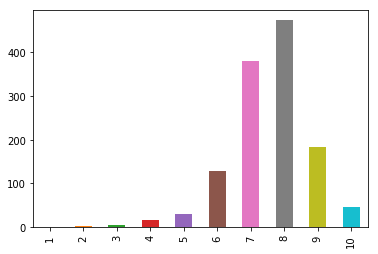

In [28]:
search_for_word('lekker', df, minimum_number_of_occurences=3)

## Average ratings per reviewer

In [19]:
df_mean_count_rating = df.groupby('reviewer').agg({'rating': ['mean', 'count']})

In [20]:
# Reviewers die alleen onvoldoendes geven
df_mean_count_rating[df_mean_count_rating[('rating', 'mean')] < 5.5].shape

(2273, 2)

In [21]:
# Reviewers die alleen onvoldoendes geven (en meer dan 1 rating hebben gegeven)
df_mean_count_rating[(df_mean_count_rating[('rating', 'count')] > 1) & (df_mean_count_rating[('rating', 'mean')] < 5.5)].shape

(193, 2)

## Reviewer with most reviews

In [22]:
df_review_cnt = df.groupby('reviewer').count()
top_reviewer = df_review_cnt[df_review_cnt.name == df_review_cnt.name.max()].index[0]
top_reviewer

'Peter S.'

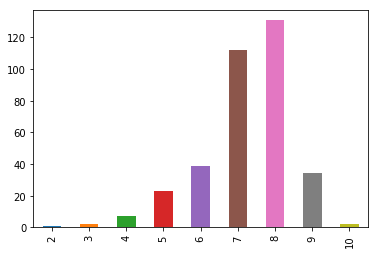

In [23]:
df[df.reviewer == top_reviewer].rating.astype(int).value_counts().sort_index().plot.bar()

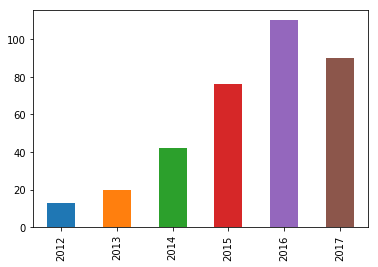

In [24]:
df[df.reviewer == top_reviewer].date.dt.year.value_counts().sort_index().plot.bar()

# Reviews over time

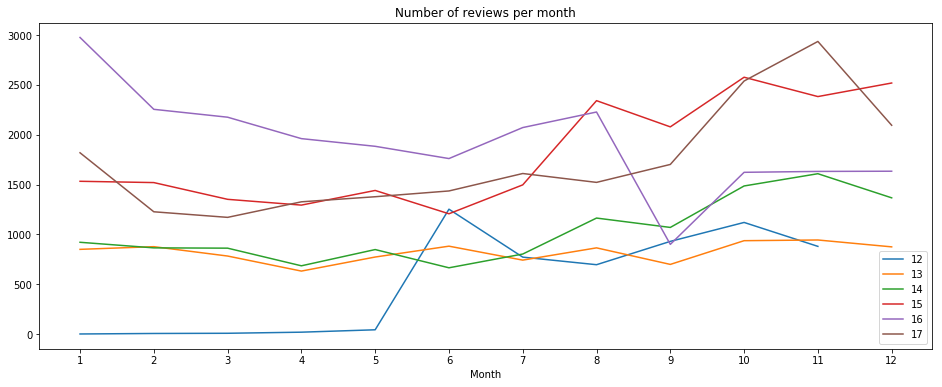

In [30]:
fig, ax = plt.subplots(1,1)

for name, grp in (
    df
    .assign(nr_reviews=1)
    .groupby(['year', 'month'])
    .agg({'nr_reviews' : sum})
    .groupby('year')
):
    grp.nr_reviews.plot(figsize=(16,6), title='Number of reviews per month', label=name, ax=ax) 

ax.set_xlabel('Month')
ax.set_xticks(range(12))
ax.set_xticklabels(range(1,13))
ax.legend()

# Average rating over time: rating increases over time!

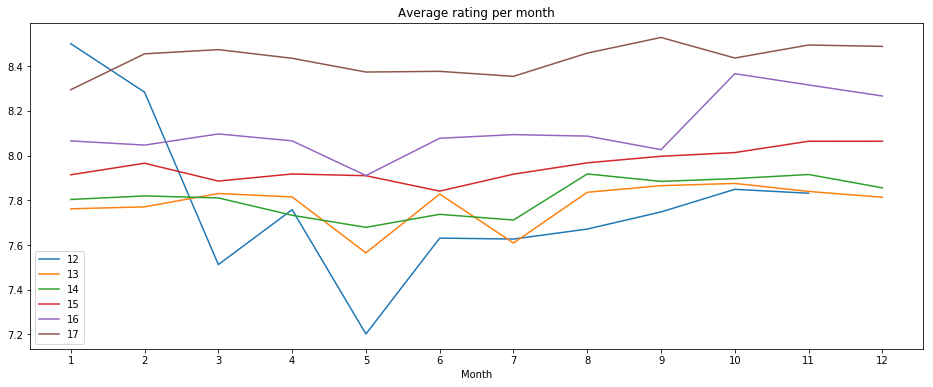

In [33]:
fig, ax = plt.subplots(1,1)

for name, grp in (
    df
    .groupby(['year', 'month'])
    .agg({'rating' : np.mean})
    .groupby('year')
):
    grp.rating.plot(figsize=(16,6), title='Average rating per month', label=name, ax=ax) 

ax.set_xlabel('Month')
ax.set_xticks(range(12))
ax.set_xticklabels(range(1,13))
ax.legend()

# Plot on map

In [43]:
import collections
Coords = collections.namedtuple('Coordinates', 'lat lon')
coords_gdd = Coords(lat=52.352379, lon=4.912933)

In [44]:
import geopy.distance
import folium
from folium.features import DivIcon

In [72]:
def plot_map(df, coords_center, range_in_km=1, min_rating=8, zoom_start=15):
    m = folium.Map(location=list(coords_center), zoom_start=zoom_start)

    for lat, lon, rating in zip(df.info_lat, df.info_lon, df.reviews_rating):
        if rating != -1 and rating >= min_rating and geopy.distance.vincenty(coords_center, (lat,lon)).km < range_in_km:
            folium.map.Marker([lat, lon], icon=DivIcon(
                html=f'<div style="font-size: 10pt; display: inline-block; background-color: white; border-width: thin; border-style: solid; border-color:#5DBCD2">{rating}</div>')
                             ).add_to(m)

    folium.map.Marker(
        list(coords_center),
        icon=DivIcon(
            html='<div style="font-size: 10pt; display: inline-block; background-color:#5DBCD2; color:white; border-width: thin; border-style: solid; border-color:#5DBCD2"> GDD </div>',
            )
        ).add_to(m)
    return m

In [73]:
plot_map(df_res, coords_gdd, range_in_km=1, min_rating=9)

## Average price distribution

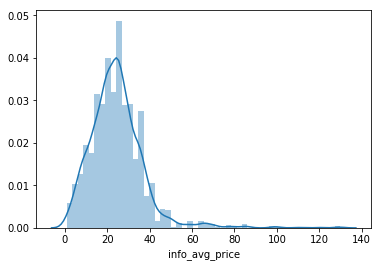

In [114]:
sns.distplot(df_res.query('info_avg_price != -1')['info_avg_price'])

### freshness of score

In [126]:
df['days_ago'] =  (pd.datetime.today() - df['date']).dt.days

In [150]:
df['freshness'] = 1 / np.log(df['days_ago'])

In [176]:
def rating_weigthed_freshness(s):
    return np.average(df.loc[s.index]['rating'], weights=df.loc[s.index]['freshness'])

In [179]:
df.groupby('name').agg(rating_weigthed_freshness)

,reserved_online,id,rating_service,date,rating_food,rating_decor,reviewer,rating,comment,yearmonth,year,month,months_ago,days_ago,freshness
name,,,,,,,,,,,,,,,
Yoghurt Barn Amsterdam,7.201474,7.201474,7.201474,7.201474,7.201474,7.201474,7.201474,7.201474,7.201474,7.201474,7.201474,7.201474,7.201474,7.201474,7.201474
&moshik,8.502679,8.502679,8.502679,8.502679,8.502679,8.502679,8.502679,8.502679,8.502679,8.502679,8.502679,8.502679,8.502679,8.502679,8.502679
'cause BEER loves FOOD,8.033089,8.033089,8.033089,8.033089,8.033089,8.033089,8.033089,8.033089,8.033089,8.033089,8.033089,8.033089,8.033089,8.033089,8.033089
't Blaauwhooft,7.843654,7.843654,7.843654,7.843654,7.843654,7.843654,7.843654,7.843654,7.843654,7.843654,7.843654,7.843654,7.843654,7.843654,7.843654
't Gasthuys,7.257356,7.257356,7.257356,7.257356,7.257356,7.257356,7.257356,7.257356,7.257356,7.257356,7.257356,7.257356,7.257356,7.257356,7.257356
't Houtskooltje,7.602139,7.602139,7.602139,7.602139,7.602139,7.602139,7.602139,7.602139,7.602139,7.602139,7.602139,7.602139,7.602139,7.602139,7.602139
't Kalfje,8.006143,8.006143,8.006143,8.006143,8.006143,8.006143,8.006143,8.006143,8.006143,8.006143,8.006143,8.006143,8.006143,8.006143,8.006143
't Kuyltje,8.972459,8.972459,8.972459,8.972459,8.972459,8.972459,8.972459,8.972459,8.972459,8.972459,8.972459,8.972459,8.972459,8.972459,8.972459
't Markerhuisje,8.340430,8.340430,8.340430,8.340430,8.340430,8.340430,8.340430,8.340430,8.340430,8.340430,8.340430,8.340430,8.340430,8.340430,8.340430


In [178]:
df.groupby('name')['rating'].agg('mean')

name
 Yoghurt Barn Amsterdam            7.215789
&moshik                            8.468508
'cause BEER loves FOOD             8.075000
't Blaauwhooft                     7.905556
't Gasthuys                        7.280000
't Houtskooltje                    7.683333
't Kalfje                          8.000000
't Kuyltje                         8.960000
't Markerhuisje                    8.315686
't Molenpad                        8.118182
't Nieuwe Kafé                     6.966667
't Oostpoortje                     7.392857
't Paardje                         6.592857
't Sluisje                         8.388889
't Steakhouse                      7.711204
't Tuinfeest                       6.450000
't Vliegertje                      8.354148
't Wethoudertje                    8.182609
't Zwaantje                        6.793333
5&33                               7.755696
63graden Foodbar                   9.280769
??Mangiancora                      8.350000
@7                         